In [3]:
import pandas as pd 
from functools import reduce
import pickle
import time
from collections import defaultdict
import os
import numpy as np
import matplotlib.pyplot as plt

block_list = [400000]

df = pd.read_pickle('../../pickles/df/400000.pickle')

# New columns for number of input and output transaction ids
df['num_txo'] = df.groupby('id_t')['id_txo_out'].transform('nunique')
df['num_txi'] = df.groupby('id_t')['id_txi'].transform('nunique')

In [4]:
#CHANGE LATER TO QUERY DATABASE INSTEAD

def tx_from_iadr(iadr):
    return set(df['id_t'][df["iadr"] == iadr])

def tx_from_oadr(oadr):
    return set(df['id_t'][df["oadr"] == oadr])

def iadrs_from_tx(id_t):
    return set(df['iadr'][df["id_t"] == id_t])

def oadrs_from_tx(id_t):
    return set(df['oadr'][df["id_t"] == id_t])

def block_from_tx(id_t):
    return set(df['block_no'][df["id_t"] == id_t])

class Addr:
    def __init__(self):
        self.adr = None
        self.sending_tx = set()
        self.receiving_tx = set()
        self.blocks = set()
        self.adr_rec_from = set()
        self.adr_sent_to = set()
        self.iadr_shared = set()
        self.oadr_shared = set()

adrs = []
already_seen_adr = set()

for iadr in set(df.iadr):
    a = Addr()
    a.adr = iadr
    st = tx_from_iadr(iadr)
    rt = tx_from_oadr(iadr)
    a.sending_tx.update(st)
    a.receiving_tx.update(rt)
    for t in st:
        a.adr_sent_to.update(oadrs_from_tx(t))
        shared = iadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.iadr_shared.update(shared)
    for t in rt:
        a.adr_rec_from.update(iadrs_from_tx(t))
        shared = oadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.oadr_shared.update(shared)
    already_seen_adr.add(iadr)
    adrs.append(a)
    
for oadr in set(df.oadr):
    if oadr not in already_seen_adr:
        a = Addr()
        a.adr = oadr
        rt = tx_from_oadr(oadr)
        a.receiving_tx.update(rt)
        for t in rt:
            a.adr_rec_from.update(iadrs_from_tx(t))
            shared = oadrs_from_tx(t)
            shared.remove(oadr)
            if shared:
                a.oadr_shared.update(shared)
        already_seen_adr.add(oadr) 
        adrs.append(a)
        
#WHICH ADDRS IN HAVE TRANSACTED WITH EACH OTHER
edges = []
for adr in adrs:
    a_s=adr.adr_sent_to
    a_r=adr.adr_rec_from
    if(a_s):
        for sadr in a_s:
            edges.append((adr.adr,sadr)) 
    if(a_r):
        for radr in a_r:
            edges.append((radr,adr.adr))

# _num_send_tx = [len(_adr.sending_tx) for _adr in adrs]
# _num_rec_tx = [len(_adr.receiving_tx) for _adr in adrs]

# adr_df = pd.DataFrame(_adrs,columns=['addrs'])

# adr_df['num_send_tx'] = _num_send_tx
# adr_df['num_rec_tx'] = _num_rec_tx
# adr_df['category'] = 'unknown'

#Max Sent
#Min Sent
#Max Rec
#Min_Rec
#Total_Sent
#Total_Rec

In [32]:
# addr input features
addr_input_df = df.groupby('iadr').agg({
    'id_txo_out': 'nunique', #Num unique times paid out
    'oadr':'nunique', #Num of unique out addresses paid out
    'id_t': 'nunique', #Num Txs involved in
    'input_val': ['max', 'min']
})

addr_input_df.columns = ['_'.join(col) for col in addr_input_df.columns]

addr_input_df.rename(columns={
    'id_txo_out_nunique': 'unique_sent', #Num of unique outputs coming from the transaction
    'oadr_nunique': 'unique_sent_adr',
    'id_t_nunique': 'num_send_tx',
    'input_val_max': 'max_sent',
    'input_val_min': 'min_sent'
}, inplace=True)

addr_input_df['total_sent'] = (df['input_val'] / df['num_txo']).groupby(df['iadr']).sum()

# addr input features
addr_out_df = df.groupby('oadr').agg({
    'id_txi': 'nunique', #Num unique times paid in
    'iadr': 'nunique', #Num of unique in addresses paid this address
    'id_t': 'nunique', #Num Txs involved in
    'output_val': ['max', 'min']
})

addr_out_df.columns = ['_'.join(col) for col in addr_out_df.columns]

addr_out_df.rename(columns={
    'id_txi_nunique': 'unique_rec',
    'iadr_nunique': 'unique_rec_adr',
    'id_t_nunique': 'num_receiving_tx',
    'output_val_max': 'max_rec',
    'output_val_min': 'min_rec'
}, inplace=True)

addr_out_df['total_rec'] = (df['output_val'] / df['num_txi']).groupby(df['oadr']).sum()

adr_df = addr_input_df.merge(addr_out_df, how='outer', left_index=True, right_index=True)

adr_df.fillna(0, inplace=True)
#Add column to indicate labelled users
adr_df["category"] = "unknown"

In [40]:
_adrs = [_adr.adr for _adr in adrs]
_num_iadr_shared = [len(_adr.iadr_shared) for _adr in adrs]
_num_oadr_shared = [len(_adr.oadr_shared) for _adr in adrs]

x = set(df.iadr).difference(set(df.oadr))
for i,a in enumerate(_adrs):
    adr_df.loc[a, 'num_iadr_shared'] = _num_iadr_shared[i]
    adr_df.loc[a, 'num_oadr_shared'] = _num_oadr_shared[i]

In [45]:
df.loc[df['id_t']==113000255]

,iadr,id_t,id_txi,id_txo_in,id_txo_out,input_val,oadr,output_val,num_txo,num_txi
15649,19de7CVFvNwzApDcRL1fr8pzDxDoLiRHrB,113000255,449165244,876587869,876892102,0.016317,1111111111111111111114oLvT2,0.000063,2,1
15650,19de7CVFvNwzApDcRL1fr8pzDxDoLiRHrB,113000255,449165244,876587869,876892101,0.016317,19de7CVFvNwzApDcRL1fr8pzDxDoLiRHrB,0.015990,2,1


In [41]:
adr_df

,num_send_tx,max_sent,min_sent,unique_sent_adr,unique_sent,total_sent,num_receiving_tx,unique_rec,max_rec,min_rec,unique_rec_adr,total_rec,category,num_iadr_shared,num_oadr_shared
0,1.0,0.000000,0.000000,1.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,unknown,0.0,0.0
1111111111111111111114oLvT2,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,1.0,0.000063,0.000063,1.0,0.000063,unknown,0.0,1.0
1127n97VdXgdPJCY1BfcSHahDoyQ3VUMt9,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,2.0,0.001494,0.001494,2.0,0.001494,unknown,0.0,1.0
112Mk5dWHsCRT1mzxQgzWPFqoV5EneR8kM,1.0,0.025000,0.025000,1.0,1.0,0.025000,0.0,0.0,0.000000,0.000000,0.0,0.000000,unknown,71.0,0.0
112V8cEeQa4HF7pTNw4ehpWNnDJtFz3VeK,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,2.0,0.141713,0.141713,2.0,0.141713,unknown,0.0,1.0
112guu3fDfo8s6cC2LoApJdLbMNvx63dsb,1.0,8.702000,8.702000,1.0,1.0,8.702000,1.0,1.0,8.702000,8.702000,1.0,8.702000,unknown,0.0,1.0
112uT4y5JyrsSqPS8cQ6nTbH7aqH5NdX4E,1.0,0.594000,0.594000,2.0,2.0,0.594000,1.0,1.0,0.055692,0.055692,1.0,0.055692,unknown,0.0,1.0
112vuRrr82QsR34ZkHD3ZR5s8CDQPP3bvS,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,5.0,0.519900,0.519900,5.0,0.519900,unknown,0.0,2.0
1132gTtFtZQTjvpvE4fXPZhTmWPwMaA2r8,1.0,0.000179,0.000179,2.0,2.0,0.000179,0.0,0.0,0.000000,0.000000,0.0,0.000000,unknown,4.0,0.0
113nMsoy9XjmSC9GBFhsqTUtysZxkkZr32,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,5.0,0.051900,0.051900,5.0,0.051900,unknown,0.0,2.0


## Tag addresses

In [33]:
#Dictionary structure - 
#'Address': 'Category'
categories = ['exchanges','gambling','pool']
dic_addrlabels = defaultdict(set)
starttime = time.time() 

for category in categories:
    #for block in range(first_block,last_block+1,1):
    for block in block_list:
        category_df = pd.read_pickle('../../pickles/categories/{}.pickle'.format(category))
        addr = category_df.loc[category_df['last used in block'] == block]['address'].tolist()
        if(len(addr)!=0):
            for a in addr:
                dic_addrlabels[a].add(category)
print("Total time to dict:", time.time()-starttime)

Total time to dict: 2.0699892044067383


In [34]:
for key in dic_addrlabels:
    adr_df.loc[key, 'category'] = dic_addrlabels[key] #label[cat.pop()]  
adr_df = adr_df.dropna(axis=0,how='any')

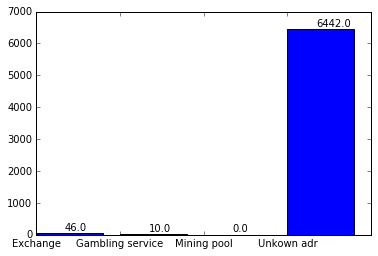

In [36]:
exchanges = np.sum(adr_df["category"] == 'exchanges') # or just sum over column, bc its binary
gambling = np.sum(adr_df["category"] == 'gambling') # or just sum over column, bc its binary
pool = np.sum(adr_df["category"] == 'pool')
unknown = np.sum(adr_df["category"] == 'unknown')

fig, ax = plt.subplots()
exchanges, gambling, pool,unknown = plt.bar((0,1,2,3), (exchanges, gambling, pool,unknown))
gambling.set_facecolor('dimgray')
pool.set_facecolor('lightgray')
ax.set_xticks((0,1,2,3))
for p in (ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.34, p.get_height() +100), fontsize=10)
ax.set_xticklabels(['Exchange', 'Gambling service', 'Mining pool', 'Unkown adr'])